# Using a WGAN-GP to Generate Stress-strain Curves

## Problem Definition

Assuming bi-linear stress strain behavior of a material (characterized by $\sigma_y$, $E$, and $H$), generate sample stress-strain curves based on some initial samples of a stress-strain curve distrbution. 

<img src="bilinear.png" alt="Drawing" style="width: 300px;"/>

## Generating the training data

The training samples will be gathered by asuming independent, normal distributions for $\sigma_y$, $E$, and $H$.

  * $\sigma_y \sim \mathcal{N}(\mu=10, \sigma=0.5)$
  * $E \sim \mathcal{N}(\mu=1000, \sigma=50)$
  * $H \sim \mathcal{N}(\mu=50, \sigma=5)$

In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

Two helper functions

In [2]:
def get_stress(strains, E, s_y, H):
    e_y = s_y / E
    elastic_strains = strains.copy()
    elastic_strains[elastic_strains > e_y] = e_y
    plastic_strains = strains - elastic_strains
    stresses = elastic_strains*E + plastic_strains*H
    return stresses

In [3]:
def generate_samples(max_strain, n_strain, n_samples):
    strain = np.linspace(0, max_strain, n_strain + 1)[1:]
    stresses = np.empty((n_samples, n_strain))
    for i in tqdm(range(n_samples), desc='Generating samples'):
        E = np.random.normal(1000, 50)
        s_y = np.random.normal(10, 0.5)
        H = np.random.normal(50, 5)
        stresses[i] = get_stress(strain, E, s_y, H)
    return stresses, strain

Make training data:

  * rows in stress_mat correspond to the stresses in a single stress strain curve (i.e. 1 sample)
  * columns in stress_mat correspond to a single strain value

In [4]:
N_SAMPLES = 100000
MAX_STRAIN = 0.02
NUM_STRAINS = 10

stress_mat, strains = generate_samples(MAX_STRAIN, NUM_STRAINS, N_SAMPLES)

Generating samples: 100%|██████████| 100000/100000 [00:00<00:00, 112484.05it/s]


## Train a GAN to produce samples that match this distribution

In [5]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import functools
from ipywidgets import interact, fixed
import ipywidgets as widgets

### Hepler Functions

In [6]:
def standardize(data):
    scaler = StandardScaler()
    scaler.fit(data)
    standardized_data = scaler.transform(data)
    
    return standardized_data, scaler

In [7]:
def normalize(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    standardized_data = scaler.transform(data)
    
    return normalized_data, scaler

In [8]:
def generate_stress_samples(n_samples, preprocessing):
    stresses, _ = generate_samples(MAX_STRAIN, NUM_STRAINS, n_samples)
    stresses = np.array(stresses)
    
    scaled_stresses, stress_scaler = preprocessing(stresses)
    
    return scaled_stresses, stress_scaler

In [9]:
def plot(variable, labels, x_label, y_label, title):
    for values, label in zip(variable, labels):
        plt.plot(values, label=label)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title)
    plt.tight_layout()

In [10]:
def plot_scatter(y_values, x_values, labels, x_label, y_label, title):
    for y_value, label in zip(y_values, labels):
        plt.scatter(np.expand_dims(x_values, -1), np.expand_dims(y_value, -1), label=label)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title)
    plt.tight_layout()

In [11]:
def plot_hist(x_values, y_values, x_label, y_label, x):
    fig, (ax_left, ax_right) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(16, 7))

    sns.violinplot(data=pd.DataFrame(data=y_values, columns=np.round(x_values, 3)), ax=ax_left)
    ax_left.set(xlabel=x_label, ylabel=y_label)
                                                                              
    itemindex = np.argmin(abs(x_values-x))
    sns.distplot(y_values[:, itemindex], bins=20)
    ax_right.set(xlim=(np.min(y_values), np.max(y_values)), xlabel='stresses at strain of %.3f' % x_values[itemindex])    

In [12]:
def plot_hist_comparison(x_values, y_values, y_values_2, x_label, y_label, x):
    fig, (ax_left, ax_right) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(16, 7))

    sns.violinplot(data=pd.DataFrame(data=y_values, columns=np.round(x_values, 3)), ax=ax_left)
    ax_left.set(xlabel=x_label, ylabel=y_label)
                                                                              
    itemindex = np.argmin(abs(x_values-x))
    sns.distplot(y_values[:, itemindex], color="blue", bins=20, label='y_values')
    if np.any(y_values_2):
        sns.distplot(y_values_2[:, itemindex], color="red", bins=20, label='y_values_2')
    plt.legend()
    ax_right.set(xlim=(np.min(y_values), np.max(y_values)), xlabel='stresses at strain of %.3f' % x_values[itemindex])
    plt.savefig('data_dist.png')

In [13]:
def plot_all_hist(x_values, y_values, y_values_2):
    f, axes = plt.subplots(int(len(x_values)/2), int(len(x_values)/(len(x_values)/2)), figsize=(15, 15), sharex=False)
    for i in range(len(x_values)):
        sns.distplot(y_values[:, i] , color="blue", bins=20, label='y_values', ax=axes[i % int(len(x_values)/2), 0 if i < len(x_values)/2 else 1])
        sns.distplot(y_values_2[:, i] , color="red", bins=20, label='y_values_2', ax=axes[i % int(len(x_values)/2), 0 if i < len(x_values)/2 else 1])
        axes[i % int(len(x_values)/2), 0 if i < len(x_values)/2 else 1].set(xlim=(np.min(y_values), np.max(y_values)), xlabel='stresses at strain of %.3f' % x_values[i])
        
    plt.tight_layout()
    plt.savefig('data_dist.png')

In [14]:
def plot_individual_sample(sample, n):
    fig = plt.figure(n)
    stress_ax = plt.plot(strains, sample)
    
    plt.xlabel('strain')
    plt.ylabel('stress')
    plt.title('Stress-Strain Curve ' + str(n + 1))
    plt.tight_layout()

### Visualize the training distribution

In [15]:
interact(plot_hist, x_values=fixed(strains), y_values=fixed(stress_mat), x_label=fixed('strain'), y_label=fixed('stress'), x=(0.0, 0.02, 0.002))

interactive(children=(FloatSlider(value=0.01, description='x', max=0.02, step=0.002), Output()), _dom_classes=…

<function __main__.plot_hist(x_values, y_values, x_label, y_label, x)>

### Settings

In [16]:
EPOCHS = 150
N_SAMPLES = 1024
BATCH_SIZE = 16
ITERATIONS = int(N_SAMPLES/BATCH_SIZE)
NOISE_DIM = 3

In [17]:
DIM = 512 # Model dimensionality
LAMBDA = .1 # Smaller lambda makes things faster for toy tasks, but isn't
            # necessary if you increase CRITIC_ITERS enough
CRITIC_ITERS = 5 # How many critic iterations per generator iteration

### 1. Preparing the dataset

In [18]:
dataset, scaler = generate_stress_samples(N_SAMPLES, standardize)
np.random.shuffle(dataset)

Generating samples: 100%|██████████| 1024/1024 [00:00<00:00, 77321.32it/s]


### 2. Create Models

* #### Generator

In [19]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(NOISE_DIM,)))
    model.add(layers.Dense(DIM, use_bias=False))
    #model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(DIM, use_bias=False))
    #model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(10, use_bias=False))
    
    return model
    

In [20]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262144    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5120      
Total params: 268,800
Trainable params: 268,800
Non-trainable params: 0
__________________________________________________

* #### Discriminator

In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(10,)))
    model.add(layers.Dense(DIM))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(DIM))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(10))
    model.add(layers.Dense(1))
    
    return model

In [22]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

### 3. Define loss and optimizers

In [23]:
accuracy = tf.keras.metrics.BinaryAccuracy()

* #### Gradient Penalty (TF2 Git)

In [24]:
def gradient_penalty(disc, real, fake):
    real = tf.cast(real, tf.float32)
    
    def _interpolate(a, b):
        #shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
        #alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
        #inter = a + alpha * (b - a)
        #inter.set_shape(a.shape)
        
        alpha = tf.random.uniform(shape=[BATCH_SIZE, 1], minval=0., maxval=1.)
        inter = alpha * a + ((1 - alpha) * b)
        
        return inter

    x = _interpolate(real, fake)
    
    with tf.GradientTape() as t:
        t.watch(x)
        pred = disc(x)
        
    grad = t.gradient(pred, x)
    #norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    #gp = tf.reduce_mean((norm - 1.)**2)

    slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1]))
    gp = tf.reduce_mean((slopes - 1) ** 2)
    
    return gp

* #### Discriminator loss

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output) 
    total_loss = real_loss + fake_loss
    return total_loss

* #### Discriminator accuracy

In [26]:
def discriminator_accuracy(real_output, fake_output):
    accuracy.update_state(tf.ones_like(real_output), real_output)
    accuracy.update_state(tf.zeros_like(fake_output), fake_output)

* #### Generator loss

In [27]:
def generator_loss(fake_output):
    loss = -tf.reduce_mean(fake_output)
    return loss

* #### Optimizers

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.5, beta_2=0.9)

### 4. Training
* #### Save checkpoints

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

* #### Generator Training Step

In [30]:
@tf.function
def generator_train_step():
    with tf.GradientTape() as gen_tape:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_batch = generator(noise, training=True)
        
        fake_output = discriminator(generated_batch, training=True)
        
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss

* #### Discriminator Training Step

In [31]:
@tf.function
def discriminator_train_step(batch):
    with tf.GradientTape() as disc_tape:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_batch = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_batch, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gp = gradient_penalty(functools.partial(discriminator, training=True), batch, generated_batch)

        disc_loss += (gp * LAMBDA)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    discriminator_accuracy(real_output, fake_output)

    return disc_loss

* #### Training

In [32]:
def train(epochs):
    losses_per_epoch = []
    disc_accuracy = []
    
    for epoch in range(epochs):
        start = time.time()
        
        for iteration in tqdm(range(ITERATIONS)):
            iter_start = time.time()
            
            sample_batch = dataset[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]
            
            disc_loss = discriminator_train_step(sample_batch)
            
            if iteration % CRITIC_ITERS == 0:
                gen_loss = generator_train_step()
                
            if (iteration + 1) % 1000 == 0:
                    print('Time for iteration {} is {:.5f} sec'.format(iteration + 1, time.time() - iter_start))
                
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print('Time for epoch {} is {:.5f} sec'.format(epoch + 1, time.time() - start))
        print("Discriminator loss: {:.4f}\t Generator loss: {:.4f}\n".format(disc_loss.numpy(), gen_loss.numpy()))
        print('Discriminator accuracy: {}\n'.format(accuracy.result().numpy()))
        losses_per_epoch.append([disc_loss, gen_loss])
        disc_accuracy.append(accuracy.result().numpy())

    return np.array(losses_per_epoch), disc_accuracy

In [33]:
%%time
losses_per_epoch, disc_accuracy = train(EPOCHS)

  0%|          | 0/64 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0625 16:06:36.576932 140226177550144 deprecation.py:323] From /home/jcuevas7/anaconda3/envs/tf2-beta1/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 1 is 4.20880 sec
Discriminator loss: -1.2841	 Generator loss: -0.2569

Discriminator accuracy: 0.81396484375

Time for epoch 2 is 0.14725 sec
Discriminator loss: -3.0777	 Generator loss: -1.1500

Discriminator accuracy: 0.7587890625



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 3 is 0.14523 sec
Discriminator loss: -3.4977	 Generator loss: -2.4382

Discriminator accuracy: 0.6834309697151184

Time for epoch 4 is 0.13957 sec
Discriminator loss: -2.1588	 Generator loss: -4.4975

Discriminator accuracy: 0.63818359375



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 5 is 0.17361 sec
Discriminator loss: 1.3977	 Generator loss: -7.4364

Discriminator accuracy: 0.6107422113418579

Time for epoch 6 is 0.14165 sec
Discriminator loss: 0.9295	 Generator loss: -11.7992

Discriminator accuracy: 0.592529296875



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 7 is 0.15823 sec
Discriminator loss: 2.0928	 Generator loss: -9.8911

Discriminator accuracy: 0.5800083875656128

Time for epoch 8 is 0.15136 sec
Discriminator loss: 3.3701	 Generator loss: -5.9686

Discriminator accuracy: 0.571533203125



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 9 is 0.15150 sec
Discriminator loss: 2.9806	 Generator loss: -5.7932

Discriminator accuracy: 0.5651041865348816

Time for epoch 10 is 0.16438 sec
Discriminator loss: 3.8864	 Generator loss: -5.6485

Discriminator accuracy: 0.5608886480331421



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 11 is 0.14638 sec
Discriminator loss: 0.3077	 Generator loss: -0.4027

Discriminator accuracy: 0.5558416247367859

Time for epoch 12 is 0.14263 sec
Discriminator loss: 1.6506	 Generator loss: 0.8390

Discriminator accuracy: 0.5481364130973816



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 13 is 0.15009 sec
Discriminator loss: -0.0435	 Generator loss: 2.9300

Discriminator accuracy: 0.541428804397583

Time for epoch 14 is 0.15110 sec
Discriminator loss: -0.1010	 Generator loss: 4.7154

Discriminator accuracy: 0.538330078125



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 15 is 0.17356 sec
Discriminator loss: -2.2539	 Generator loss: 4.2299

Discriminator accuracy: 0.5357747673988342

Time for epoch 16 is 0.14080 sec
Discriminator loss: -1.4047	 Generator loss: 4.3334

Discriminator accuracy: 0.533538818359375



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 17 is 0.14228 sec
Discriminator loss: -0.5181	 Generator loss: 2.9221

Discriminator accuracy: 0.5315659642219543

Time for epoch 18 is 0.13939 sec
Discriminator loss: -0.3573	 Generator loss: 1.7572

Discriminator accuracy: 0.5298122763633728



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 19 is 0.14070 sec
Discriminator loss: -0.5437	 Generator loss: 0.5459

Discriminator accuracy: 0.5304790139198303

Time for epoch 20 is 0.18204 sec
Discriminator loss: 0.7898	 Generator loss: -1.4619

Discriminator accuracy: 0.532421886920929



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 21 is 0.14950 sec
Discriminator loss: 0.1986	 Generator loss: -2.2401

Discriminator accuracy: 0.5327380895614624

Time for epoch 22 is 0.13637 sec
Discriminator loss: 2.4222	 Generator loss: -2.9448

Discriminator accuracy: 0.5310946106910706



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 23 is 0.13982 sec
Discriminator loss: 1.6298	 Generator loss: -1.2856

Discriminator accuracy: 0.5292331576347351

Time for epoch 24 is 0.13567 sec
Discriminator loss: -0.3890	 Generator loss: 0.6830

Discriminator accuracy: 0.5270588994026184



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 25 is 0.16246 sec
Discriminator loss: -0.7237	 Generator loss: 2.3407

Discriminator accuracy: 0.5254492163658142

Time for epoch 26 is 0.13508 sec
Discriminator loss: -1.0734	 Generator loss: 3.8135

Discriminator accuracy: 0.5247520804405212



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 27 is 0.15218 sec
Discriminator loss: -1.6874	 Generator loss: 3.4963

Discriminator accuracy: 0.5236725807189941

Time for epoch 28 is 0.14635 sec
Discriminator loss: -1.0658	 Generator loss: 2.0526

Discriminator accuracy: 0.5229143500328064



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 29 is 0.14071 sec
Discriminator loss: -0.3152	 Generator loss: 1.3898

Discriminator accuracy: 0.5221915245056152

Time for epoch 30 is 0.15901 sec
Discriminator loss: 0.6140	 Generator loss: 0.2806

Discriminator accuracy: 0.522167980670929



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 31 is 0.13979 sec
Discriminator loss: 0.1465	 Generator loss: -0.7742

Discriminator accuracy: 0.52294921875

Time for epoch 32 is 0.13734 sec
Discriminator loss: -0.1831	 Generator loss: -0.2765

Discriminator accuracy: 0.52301025390625



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 33 is 0.13835 sec
Discriminator loss: -0.1042	 Generator loss: 1.0706

Discriminator accuracy: 0.522520124912262

Time for epoch 34 is 0.14884 sec
Discriminator loss: -0.8182	 Generator loss: 1.5249

Discriminator accuracy: 0.521857738494873



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 35 is 0.17049 sec
Discriminator loss: -0.3713	 Generator loss: 1.5352

Discriminator accuracy: 0.5211774706840515

Time for epoch 36 is 0.14095 sec
Discriminator loss: 0.1409	 Generator loss: 1.4095

Discriminator accuracy: 0.5207112431526184



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 37 is 0.13774 sec
Discriminator loss: -0.4419	 Generator loss: 1.3971

Discriminator accuracy: 0.5203362703323364

Time for epoch 38 is 0.13616 sec
Discriminator loss: -0.7181	 Generator loss: 0.2492

Discriminator accuracy: 0.5205591917037964



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 39 is 0.13910 sec
Discriminator loss: -0.5050	 Generator loss: 0.9358

Discriminator accuracy: 0.5206705927848816

Time for epoch 40 is 0.15891 sec
Discriminator loss: -0.0287	 Generator loss: 1.0496

Discriminator accuracy: 0.520214855670929



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 41 is 0.15250 sec
Discriminator loss: -0.3009	 Generator loss: 1.2088

Discriminator accuracy: 0.52001953125

Time for epoch 42 is 0.13928 sec
Discriminator loss: 0.6323	 Generator loss: 1.1200

Discriminator accuracy: 0.5197405219078064



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 43 is 0.14420 sec
Discriminator loss: -0.3225	 Generator loss: 0.7968

Discriminator accuracy: 0.5196788907051086

Time for epoch 44 is 0.13784 sec
Discriminator loss: -0.2891	 Generator loss: 1.8738

Discriminator accuracy: 0.5194313526153564



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 45 is 0.16665 sec
Discriminator loss: -1.1003	 Generator loss: 0.1119

Discriminator accuracy: 0.519335925579071

Time for epoch 46 is 0.13896 sec
Discriminator loss: -0.1072	 Generator loss: 0.9520

Discriminator accuracy: 0.51902174949646



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 47 is 0.15323 sec
Discriminator loss: -0.5528	 Generator loss: 1.4320

Discriminator accuracy: 0.518835186958313

Time for epoch 48 is 0.15093 sec
Discriminator loss: -0.3341	 Generator loss: 2.7022

Discriminator accuracy: 0.5182088017463684



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 49 is 0.14139 sec
Discriminator loss: -0.6427	 Generator loss: 2.9639

Discriminator accuracy: 0.5177276134490967

Time for epoch 50 is 0.15815 sec
Discriminator loss: -2.4313	 Generator loss: 0.7727

Discriminator accuracy: 0.5174707174301147



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 51 is 0.14047 sec
Discriminator loss: -1.0153	 Generator loss: 1.2839

Discriminator accuracy: 0.5175589919090271

Time for epoch 52 is 0.13403 sec
Discriminator loss: 0.4325	 Generator loss: 0.6837

Discriminator accuracy: 0.5173621773719788



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 53 is 0.14114 sec
Discriminator loss: 0.1506	 Generator loss: 0.9753

Discriminator accuracy: 0.5173293948173523

Time for epoch 54 is 0.14197 sec
Discriminator loss: 0.4031	 Generator loss: 1.3164

Discriminator accuracy: 0.5174786448478699



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 55 is 0.18031 sec
Discriminator loss: -0.2415	 Generator loss: 1.1580

Discriminator accuracy: 0.5171253681182861

Time for epoch 56 is 0.14093 sec
Discriminator loss: -0.6881	 Generator loss: 1.0582

Discriminator accuracy: 0.5170549750328064



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 57 is 0.13948 sec
Discriminator loss: -0.7871	 Generator loss: 1.5220

Discriminator accuracy: 0.5168328285217285

Time for epoch 58 is 0.13445 sec
Discriminator loss: -0.0640	 Generator loss: 2.5775

Discriminator accuracy: 0.5166268348693848



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 59 is 0.14350 sec
Discriminator loss: -0.4620	 Generator loss: 1.9478

Discriminator accuracy: 0.5163118839263916

Time for epoch 60 is 0.15666 sec
Discriminator loss: -0.2731	 Generator loss: 1.6917

Discriminator accuracy: 0.5161295533180237



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 61 is 0.15348 sec
Discriminator loss: -0.7209	 Generator loss: 1.5334

Discriminator accuracy: 0.5159772038459778

Time for epoch 62 is 0.14775 sec
Discriminator loss: -0.1654	 Generator loss: 1.5938

Discriminator accuracy: 0.5158770084381104



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 63 is 0.13969 sec
Discriminator loss: -0.1051	 Generator loss: 0.9579

Discriminator accuracy: 0.515927255153656

Time for epoch 64 is 0.13886 sec
Discriminator loss: 0.1119	 Generator loss: 1.2949

Discriminator accuracy: 0.5157699584960938



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 65 is 0.16298 sec
Discriminator loss: -0.0146	 Generator loss: 1.7068

Discriminator accuracy: 0.5156700611114502

Time for epoch 66 is 0.13936 sec
Discriminator loss: -0.0144	 Generator loss: 1.7098

Discriminator accuracy: 0.5155066251754761



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 67 is 0.13788 sec
Discriminator loss: -0.2796	 Generator loss: 2.1052

Discriminator accuracy: 0.5153334736824036

Time for epoch 68 is 0.15338 sec
Discriminator loss: -0.4881	 Generator loss: 2.0296

Discriminator accuracy: 0.5151152014732361



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 69 is 0.14381 sec
Discriminator loss: -0.1446	 Generator loss: 1.8309

Discriminator accuracy: 0.51490318775177

Time for epoch 70 is 0.15878 sec
Discriminator loss: -0.4135	 Generator loss: 1.8204

Discriminator accuracy: 0.5147460699081421



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 71 is 0.13686 sec
Discriminator loss: 0.3124	 Generator loss: 2.2585

Discriminator accuracy: 0.5145590305328369

Time for epoch 72 is 0.13378 sec
Discriminator loss: 0.0010	 Generator loss: 1.6765

Discriminator accuracy: 0.5144517421722412



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 73 is 0.14404 sec
Discriminator loss: -0.3653	 Generator loss: 1.8745

Discriminator accuracy: 0.5142337083816528

Time for epoch 74 is 0.13901 sec
Discriminator loss: 0.0260	 Generator loss: 1.8202

Discriminator accuracy: 0.5141403675079346



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 75 is 0.17956 sec
Discriminator loss: -0.4655	 Generator loss: 1.1967

Discriminator accuracy: 0.51416015625

Time for epoch 76 is 0.14520 sec
Discriminator loss: -0.4408	 Generator loss: 1.7112

Discriminator accuracy: 0.5140637755393982



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 77 is 0.14231 sec
Discriminator loss: -1.0001	 Generator loss: 1.5855

Discriminator accuracy: 0.5139572620391846

Time for epoch 78 is 0.13931 sec
Discriminator loss: -0.2647	 Generator loss: 1.5212

Discriminator accuracy: 0.5138471722602844



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 79 is 0.13811 sec
Discriminator loss: -0.2325	 Generator loss: 2.1903

Discriminator accuracy: 0.5138573050498962

Time for epoch 80 is 0.16913 sec
Discriminator loss: -0.8241	 Generator loss: 1.4336

Discriminator accuracy: 0.513824462890625



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 81 is 0.15012 sec
Discriminator loss: -0.4903	 Generator loss: 3.3973

Discriminator accuracy: 0.5139371156692505

Time for epoch 82 is 0.14518 sec
Discriminator loss: -0.1890	 Generator loss: 1.5938

Discriminator accuracy: 0.5137730836868286



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 83 is 0.13867 sec
Discriminator loss: -0.0553	 Generator loss: 1.6361

Discriminator accuracy: 0.5136895179748535

Time for epoch 84 is 0.14288 sec
Discriminator loss: -0.6102	 Generator loss: 1.4022

Discriminator accuracy: 0.5137067437171936



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 85 is 0.16117 sec
Discriminator loss: -0.5817	 Generator loss: 1.5706

Discriminator accuracy: 0.5134363770484924

Time for epoch 86 is 0.13749 sec
Discriminator loss: -0.2537	 Generator loss: 2.6219

Discriminator accuracy: 0.5133652687072754



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 87 is 0.13817 sec
Discriminator loss: 0.0050	 Generator loss: 2.2839

Discriminator accuracy: 0.513301432132721

Time for epoch 88 is 0.14544 sec
Discriminator loss: 0.4442	 Generator loss: 1.6121

Discriminator accuracy: 0.5132169127464294



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 89 is 0.15192 sec
Discriminator loss: -0.8173	 Generator loss: 2.3443

Discriminator accuracy: 0.5132384300231934

Time for epoch 90 is 0.16089 sec
Discriminator loss: 0.1257	 Generator loss: 1.8673

Discriminator accuracy: 0.51318359375



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 91 is 0.13763 sec
Discriminator loss: 0.2411	 Generator loss: 1.6842

Discriminator accuracy: 0.5131406784057617

Time for epoch 92 is 0.13355 sec
Discriminator loss: -0.2410	 Generator loss: 1.5426

Discriminator accuracy: 0.5131198763847351



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 93 is 0.14094 sec
Discriminator loss: -0.3921	 Generator loss: 2.0612

Discriminator accuracy: 0.5130103230476379

Time for epoch 94 is 0.14598 sec
Discriminator loss: 0.7870	 Generator loss: 2.4446

Discriminator accuracy: 0.5129446387290955



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 95 is 0.18524 sec
Discriminator loss: 0.3203	 Generator loss: 2.1938

Discriminator accuracy: 0.5129265785217285

Time for epoch 96 is 0.14461 sec
Discriminator loss: -0.6081	 Generator loss: 2.1138

Discriminator accuracy: 0.512847900390625



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 97 is 0.13973 sec
Discriminator loss: 0.1048	 Generator loss: 1.5766

Discriminator accuracy: 0.5127758383750916

Time for epoch 98 is 0.13589 sec
Discriminator loss: -0.5992	 Generator loss: 1.5043

Discriminator accuracy: 0.5128697156906128



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 99 is 0.13766 sec
Discriminator loss: -0.5760	 Generator loss: 1.2486

Discriminator accuracy: 0.5127100944519043

Time for epoch 100 is 0.16190 sec
Discriminator loss: -0.0076	 Generator loss: 2.2670

Discriminator accuracy: 0.5125927925109863



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 101 is 0.14984 sec
Discriminator loss: -1.0187	 Generator loss: 2.4307

Discriminator accuracy: 0.5124825835227966

Time for epoch 102 is 0.14832 sec
Discriminator loss: -0.1857	 Generator loss: 2.5053

Discriminator accuracy: 0.5124176740646362



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 103 is 0.14213 sec
Discriminator loss: 0.0802	 Generator loss: 1.5768

Discriminator accuracy: 0.5123587250709534

Time for epoch 104 is 0.13832 sec
Discriminator loss: -0.1089	 Generator loss: 1.4311

Discriminator accuracy: 0.5123478770256042



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 105 is 0.16186 sec
Discriminator loss: 0.2755	 Generator loss: 1.6278

Discriminator accuracy: 0.5122302770614624

Time for epoch 106 is 0.14764 sec
Discriminator loss: 0.1257	 Generator loss: 2.5867

Discriminator accuracy: 0.5121886134147644



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 107 is 0.14182 sec
Discriminator loss: -0.6829	 Generator loss: 2.3194

Discriminator accuracy: 0.5121020674705505

Time for epoch 108 is 0.14892 sec
Discriminator loss: -0.5005	 Generator loss: 1.7472

Discriminator accuracy: 0.5120261907577515



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 109 is 0.15274 sec
Discriminator loss: -0.1993	 Generator loss: 2.5984

Discriminator accuracy: 0.5119472146034241

Time for epoch 110 is 0.15978 sec
Discriminator loss: -0.0732	 Generator loss: 2.0184

Discriminator accuracy: 0.5119229555130005



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 111 is 0.14559 sec
Discriminator loss: 0.4261	 Generator loss: 2.1068

Discriminator accuracy: 0.5118727087974548

Time for epoch 112 is 0.13739 sec
Discriminator loss: 0.0077	 Generator loss: 2.6427

Discriminator accuracy: 0.5118321180343628



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 113 is 0.14291 sec
Discriminator loss: -0.6497	 Generator loss: 1.3841

Discriminator accuracy: 0.5117489695549011

Time for epoch 114 is 0.13673 sec
Discriminator loss: -0.9361	 Generator loss: 1.9633

Discriminator accuracy: 0.5115988254547119



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 115 is 0.18533 sec
Discriminator loss: -0.1449	 Generator loss: 2.8746

Discriminator accuracy: 0.511523425579071

Time for epoch 116 is 0.15555 sec
Discriminator loss: -0.4047	 Generator loss: 2.8904

Discriminator accuracy: 0.5114367008209229



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 117 is 0.15267 sec
Discriminator loss: -0.0573	 Generator loss: 1.9373

Discriminator accuracy: 0.511414110660553

Time for epoch 118 is 0.13701 sec
Discriminator loss: -0.0385	 Generator loss: 2.1685

Discriminator accuracy: 0.5113297700881958



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 119 is 0.13757 sec
Discriminator loss: -0.2577	 Generator loss: 1.4149

Discriminator accuracy: 0.5113002061843872

Time for epoch 120 is 0.16592 sec
Discriminator loss: -0.6616	 Generator loss: 1.8147

Discriminator accuracy: 0.5112060308456421



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 121 is 0.15270 sec
Discriminator loss: -0.6521	 Generator loss: 2.1409

Discriminator accuracy: 0.5111376643180847

Time for epoch 122 is 0.15302 sec
Discriminator loss: -0.3162	 Generator loss: 3.1712

Discriminator accuracy: 0.5111023783683777



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 123 is 0.14208 sec
Discriminator loss: -0.1781	 Generator loss: 2.5607

Discriminator accuracy: 0.5110478401184082

Time for epoch 124 is 0.13927 sec
Discriminator loss: 0.0825	 Generator loss: 2.1582

Discriminator accuracy: 0.5109745264053345



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 125 is 0.17252 sec
Discriminator loss: 0.1228	 Generator loss: 2.1743

Discriminator accuracy: 0.5109140872955322

Time for epoch 126 is 0.15147 sec
Discriminator loss: -0.5017	 Generator loss: 1.9846

Discriminator accuracy: 0.5108739733695984



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 127 is 0.14535 sec
Discriminator loss: 0.2477	 Generator loss: 2.0206

Discriminator accuracy: 0.5108267664909363

Time for epoch 128 is 0.15057 sec
Discriminator loss: -0.4180	 Generator loss: 2.2491

Discriminator accuracy: 0.5107498168945312



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 129 is 0.15060 sec
Discriminator loss: -0.7184	 Generator loss: 2.7084

Discriminator accuracy: 0.5107080936431885

Time for epoch 130 is 0.16926 sec
Discriminator loss: -0.2596	 Generator loss: 2.4736

Discriminator accuracy: 0.5106370449066162



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 131 is 0.14631 sec
Discriminator loss: -0.4058	 Generator loss: 2.3729

Discriminator accuracy: 0.5105781555175781

Time for epoch 132 is 0.13941 sec
Discriminator loss: -0.5752	 Generator loss: 2.0196

Discriminator accuracy: 0.5105165243148804



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 133 is 0.14538 sec
Discriminator loss: -0.3190	 Generator loss: 2.3047

Discriminator accuracy: 0.5104668140411377

Time for epoch 134 is 0.14206 sec
Discriminator loss: 0.1978	 Generator loss: 2.7441

Discriminator accuracy: 0.5104106068611145



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 135 is 0.19142 sec
Discriminator loss: -0.0864	 Generator loss: 2.5074

Discriminator accuracy: 0.5103298425674438

Time for epoch 136 is 0.14016 sec
Discriminator loss: -0.1373	 Generator loss: 2.1756

Discriminator accuracy: 0.5102323889732361



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 137 is 0.14090 sec
Discriminator loss: -0.8415	 Generator loss: 2.2141

Discriminator accuracy: 0.5102432370185852

Time for epoch 138 is 0.13962 sec
Discriminator loss: -0.1004	 Generator loss: 1.9839

Discriminator accuracy: 0.5101795792579651



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 139 is 0.14554 sec
Discriminator loss: -0.1522	 Generator loss: 2.2642

Discriminator accuracy: 0.5100958347320557

Time for epoch 140 is 0.17772 sec
Discriminator loss: -0.2287	 Generator loss: 2.3278

Discriminator accuracy: 0.5100306868553162



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 141 is 0.15503 sec
Discriminator loss: -0.7504	 Generator loss: 2.5218

Discriminator accuracy: 0.5099837779998779

Time for epoch 142 is 0.14663 sec
Discriminator loss: -0.5292	 Generator loss: 2.2467

Discriminator accuracy: 0.5099306702613831



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 143 is 0.13981 sec
Discriminator loss: -0.2446	 Generator loss: 2.3505

Discriminator accuracy: 0.5098646283149719

Time for epoch 144 is 0.14442 sec
Discriminator loss: -0.1424	 Generator loss: 1.9778

Discriminator accuracy: 0.5098164677619934



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 145 is 0.16698 sec
Discriminator loss: 1.0452	 Generator loss: 2.0058

Discriminator accuracy: 0.5097891688346863

Time for epoch 146 is 0.13939 sec
Discriminator loss: -0.3100	 Generator loss: 1.8299

Discriminator accuracy: 0.5097923874855042



  0%|          | 0/64 [00:00<?, ?it/s]

Time for epoch 147 is 0.14295 sec
Discriminator loss: -0.4776	 Generator loss: 2.5042

Discriminator accuracy: 0.5097423791885376

Time for epoch 148 is 0.14894 sec
Discriminator loss: -0.4988	 Generator loss: 2.2257

Discriminator accuracy: 0.5097491145133972



100%|██████████| 64/64 [00:00<00:00, 472.47it/s]


Time for epoch 149 is 0.14793 sec
Discriminator loss: -0.2288	 Generator loss: 2.2680

Discriminator accuracy: 0.5097295641899109

Time for epoch 150 is 0.16027 sec
Discriminator loss: -0.4732	 Generator loss: 1.6700

Discriminator accuracy: 0.5097103118896484

CPU times: user 2min 6s, sys: 9.73 s, total: 2min 16s
Wall time: 26.5 s


### 5. Visualize Results

Generating samples: 100%|██████████| 100000/100000 [00:01<00:00, 99809.20it/s]


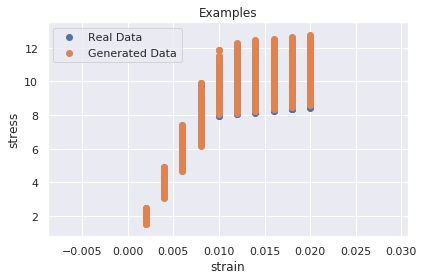

In [34]:
num_examples = 100000
seed = tf.random.normal([num_examples, NOISE_DIM])

pred = generator(seed, training=False)
unscaled_pred = scaler.inverse_transform(pred)

samples, strains = generate_samples(MAX_STRAIN, NUM_STRAINS, num_examples)

strains_for_plot = strains * np.ones((num_examples, 1))
plot_scatter([stress_mat, unscaled_pred], strains_for_plot, ['Real Data', 'Generated Data'], x_label='strain', y_label='stress', title='Examples')

plt.savefig('Examples')

* #### Plotting data distribution

In [35]:
interact(plot_hist_comparison, x_values=fixed(strains), y_values=fixed(stress_mat), y_values_2=fixed(unscaled_pred), x_label=fixed('strain'), y_label=fixed('stress'), x=(0.0, 0.02, 0.002))

interactive(children=(FloatSlider(value=0.01, description='x', max=0.02, step=0.002), Output()), _dom_classes=…

<function __main__.plot_hist_comparison(x_values, y_values, y_values_2, x_label, y_label, x)>

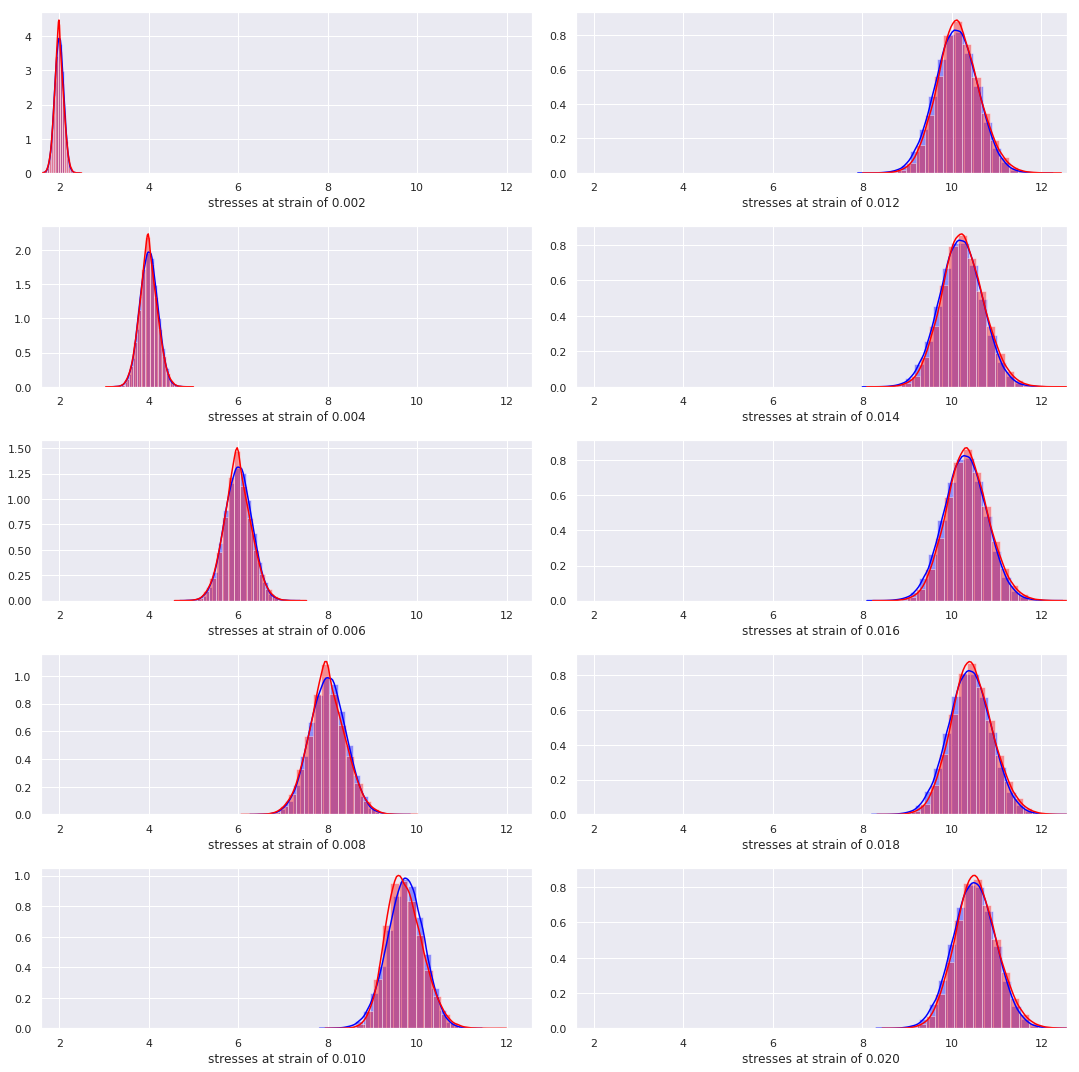

In [36]:
plot_all_hist(x_values=strains, y_values=stress_mat, y_values_2=unscaled_pred)

* #### Plotting the generator's and the discriminator's loss.

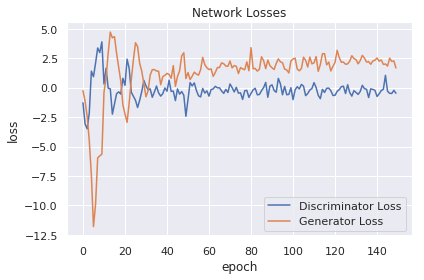

In [37]:
plot([losses_per_epoch[:,0], losses_per_epoch[:,1]], labels=['Discriminator Loss', 'Generator Loss'], x_label='epoch', y_label='loss', title='Network Losses')
plt.savefig('losses.png')

* #### Plotting Discriminator Accuracy

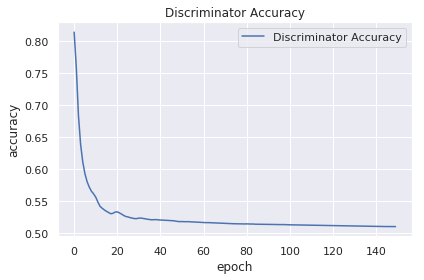

In [38]:
plot([disc_accuracy], labels=['Discriminator Accuracy'], x_label='epoch', y_label='accuracy', title=
'Discriminator Accuracy')
plt.savefig('disc_acc.png')

* #### Plotting individual samples

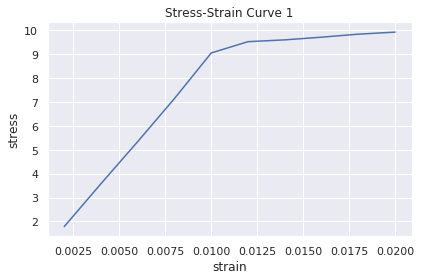

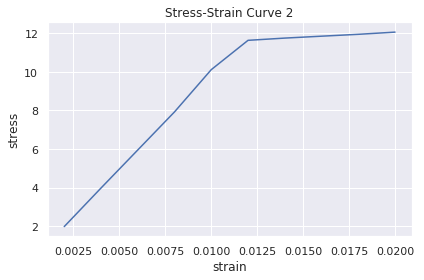

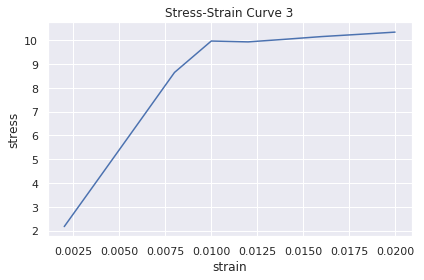

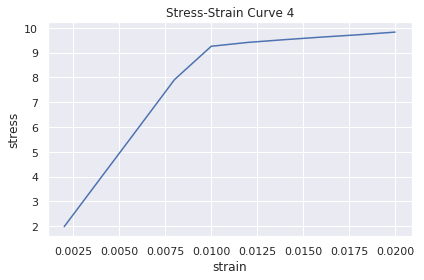

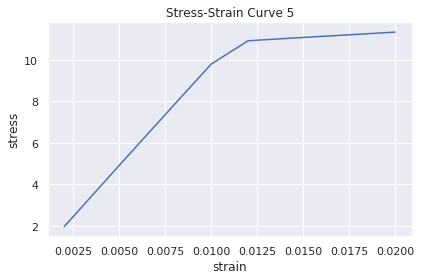

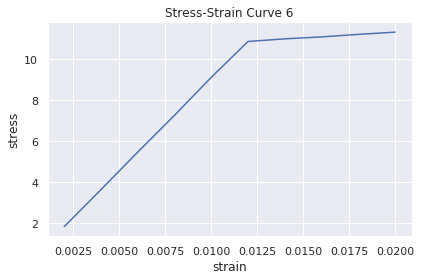

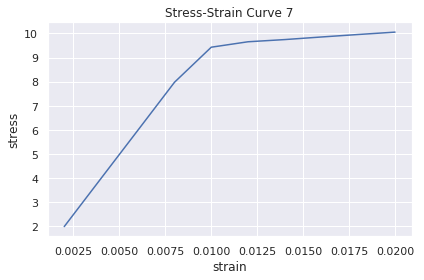

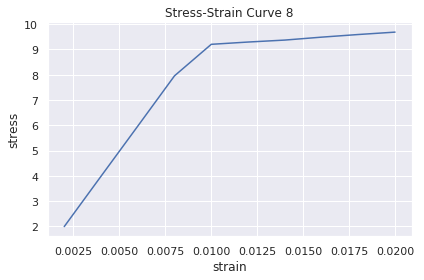

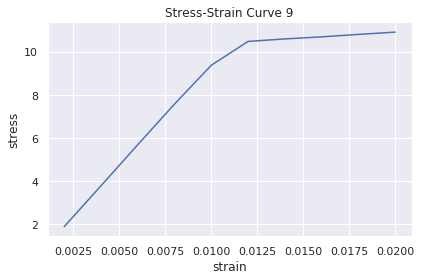

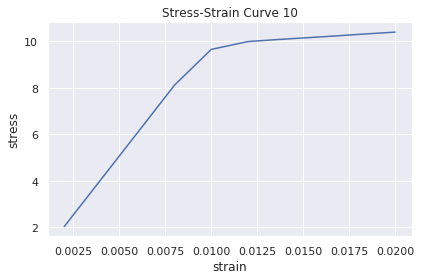

In [39]:
for i in range(10):
    plot_individual_sample(unscaled_pred[i], i)
    plt.savefig('example_curve.png')